In [ ]:
# requirements.txt file should present in current path
!pip install -r requirements.txt

In [1]:
from itertools import product

import numpy as np
import pandas as pd
import scipy.stats as ss

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input

import matplotlib.pyplot as plt
import seaborn as sns

import shap

In [2]:
data_fp = "fuel_consumption_dataset/1995-2004_Fuel_Consumption.csv"
data_df = pd.read_csv(data_fp)

In [3]:
data_df.shape

(27774, 15)

### Explolatory Data Analysis

In [4]:
data_df.columns

Index(['Model year', 'Make', 'Model', 'Vehicle class', 'Engine size (L)',
       'Cylinders', 'Transmission', 'Fuel type', 'City (L/100 km)',
       'Highway (L/100 km)', 'Combined (L/100 km)', 'Combined (mpg)',
       'CO2 emissions (g/km)', 'CO2 rating', 'Smog rating'],
      dtype='object')

In [5]:
data_df = data_df.rename(columns={
    'Model year': 'Model_Year',
    'Vehicle class': 'Vehicle_Class',
    'Engine size (L)': 'Engine_Size',
    'Fuel type': 'Fuel_Type', 
    'City (L/100 km)': 'Fuel_Consumption_City',
    'Highway (L/100 km)': 'Fuel_Consumption_Hwy',
    'Combined (L/100 km)': 'Fuel_Consumption_Comb',
    'Combined (mpg)': 'Fuel_Consumption_Comb1',
    'CO2 emissions (g/km)': 'CO2_Emissions',
    'CO2 rating': 'C02_Rating', 
    'Smog rating': 'Smog_Rating'
})

data_df.columns

Index(['Model_Year', 'Make', 'Model', 'Vehicle_Class', 'Engine_Size',
       'Cylinders', 'Transmission', 'Fuel_Type', 'Fuel_Consumption_City',
       'Fuel_Consumption_Hwy', 'Fuel_Consumption_Comb',
       'Fuel_Consumption_Comb1', 'CO2_Emissions', 'C02_Rating', 'Smog_Rating'],
      dtype='object')

In [6]:
data_df.drop(columns=["Fuel_Consumption_Comb", "Fuel_Consumption_Comb1", "C02_Rating", "Smog_Rating"], inplace=True)

In [7]:
data_df["Make"] = data_df["Make"].str.upper()
data_df["Vehicle_Class"] = data_df["Vehicle_Class"].str.upper()

In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27774 entries, 0 to 27773
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Model_Year             27774 non-null  int64  
 1   Make                   27774 non-null  object 
 2   Model                  27774 non-null  object 
 3   Vehicle_Class          27774 non-null  object 
 4   Engine_Size            27774 non-null  float64
 5   Cylinders              27774 non-null  int64  
 6   Transmission           27774 non-null  object 
 7   Fuel_Type              27774 non-null  object 
 8   Fuel_Consumption_City  27774 non-null  float64
 9   Fuel_Consumption_Hwy   27774 non-null  float64
 10  CO2_Emissions          27774 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 2.3+ MB


In [9]:
data_df.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
Model_Year,27774.0,2010.390365,8.159192,1995.0,2004.0,2011.0,2017.0,2024.0
Engine_Size,27774.0,3.340109,1.341209,0.8,2.2,3.0,4.2,8.4
Cylinders,27774.0,5.828509,1.806606,2.0,4.0,6.0,8.0,16.0
Fuel_Consumption_City,27774.0,13.802733,3.741253,4.0,11.2,13.4,15.9,33.3
Fuel_Consumption_Hwy,27774.0,9.995327,2.584483,3.9,8.2,9.5,11.4,22.1
CO2_Emissions,27774.0,275.081803,65.921779,94.0,230.0,267.0,314.0,633.0


In [10]:
data_df.describe(include=object).T

,count,unique,top,freq
Make,27774,55,CHEVROLET,2614
Model,27774,4327,Mustang,136
Vehicle_Class,27774,17,COMPACT,3833
Transmission,27774,30,A4,5491
Fuel_Type,27774,5,X,15182


In [11]:
data_df.isnull().sum()

Model_Year               0
Make                     0
Model                    0
Vehicle_Class            0
Engine_Size              0
Cylinders                0
Transmission             0
Fuel_Type                0
Fuel_Consumption_City    0
Fuel_Consumption_Hwy     0
CO2_Emissions            0
dtype: int64

In [12]:
print(f"Total Duplicated Data: {data_df.duplicated().sum()}")

Total Duplicated Data: 3


In [13]:
data_df[["Make", "Model", "Vehicle_Class"]].duplicated().sum()

22963

In [14]:
data_df.drop_duplicates(inplace=True)
data_df.reset_index(inplace=True, drop=True)
print(f"New dataset dimension is: {data_df.shape}")

New dataset dimension is: (27771, 11)


#### Correlation Analysis

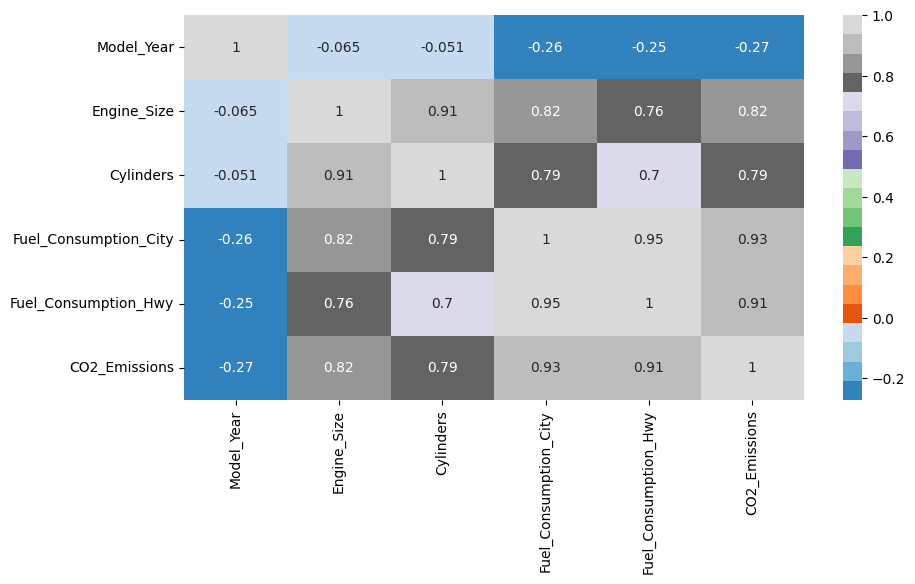

In [15]:
plt.figure(figsize=(10, 5))

num_corr = data_df.select_dtypes(include=np.number).corr(method="pearson")
sns.heatmap(num_corr, annot=True, cmap='tab20c')
# plt.savefig("figures/feat_num_correlation.png", bbox_inches="tight")
plt.show()

`gte 0.5 = strong positive correlation` \
`lte 0.5 = strong negative correlation`

Model_Year has weak negative correlation with target\
Others has strong positive correlation with target

In [16]:
cat_data = data_df.select_dtypes(include=object)
cat_data

,Make,Model,Vehicle_Class,Transmission,Fuel_Type
0,ACURA,ILX,COMPACT,AM8,Z
1,ACURA,MDX SH-AWD,SPORT UTILITY VEHICLE: SMALL,AS10,Z
2,ACURA,MDX Type S,SPORT UTILITY VEHICLE: STANDARD,AS10,Z
3,ACURA,NSX,TWO-SEATER,AM9,Z
4,ACURA,RDX SH-AWD,SPORT UTILITY VEHICLE: SMALL,AS10,Z
...,...,...,...,...,...
27766,VOLVO,XC40 B5 AWD,SPORT UTILITY VEHICLE: SMALL,AS8,Z
27767,VOLVO,XC60 B5 AWD,SPORT UTILITY VEHICLE: SMALL,AS8,Z
27768,VOLVO,XC60 B6 AWD,SPORT UTILITY VEHICLE: SMALL,AS8,Z
27769,VOLVO,XC90 B5 AWD,SPORT UTILITY VEHICLE: STANDARD,AS8,Z


In [17]:
cat_var1 = list(cat_data.columns)
cat_var2 = list(cat_data.columns)
cat_var_comb = list(product(cat_var1, cat_var2, repeat=1))

In [18]:
def ch_calculate(df):
    factors_paired = [(i,j) for i in df.columns.values for j in df.columns.values] 

    chi2, p_values =[], []

    for f in factors_paired:
        if f[0] != f[1]:
            chitest = ss.chi2_contingency(pd.crosstab(df[f[0]], df[f[1]]))   
            chi2.append(chitest[0])
            p_values.append(chitest[1])
        else:
            chi2.append(0)
            p_values.append(0)

    chi2 = np.array(chi2).reshape((len(df.columns),len(df.columns))) # shape it as a matrix
    chi2 = pd.DataFrame(chi2, index=df.columns.values, columns=df.columns.values) # then a df for convenience

    return chi2

chi2_df = ch_calculate(cat_data)
chi2_df

,Make,Model,Vehicle_Class,Transmission,Fuel_Type
Make,0.000000e+00,1.463918e+06,46777.117869,80147.118780,21109.652515
Model,1.463918e+06,0.000000e+00,408094.803017,414103.403646,78585.236070
Vehicle_Class,4.677712e+04,4.080948e+05,0.000000,25910.290116,9332.549281
Transmission,8.014712e+04,4.141034e+05,25910.290116,0.000000,11151.720511
Fuel_Type,2.110965e+04,7.858524e+04,9332.549281,11151.720511,0.000000


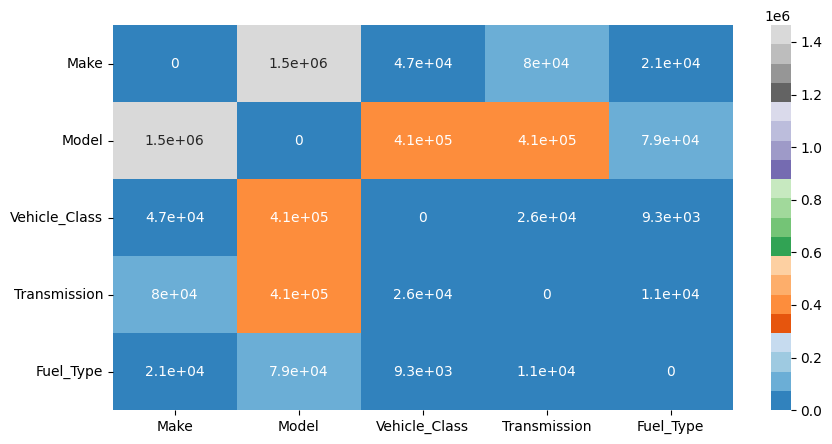

In [19]:
plt.figure(figsize=(10, 5))

sns.heatmap(chi2_df, annot=True, cmap='tab20c')
plt.savefig("figures/feat_cat_correlation.png", bbox_inches="tight")
plt.show()

p <= 0.05, there exists a relationship otherwise not

<Axes: xlabel='CO2_Emissions', ylabel='Density'>

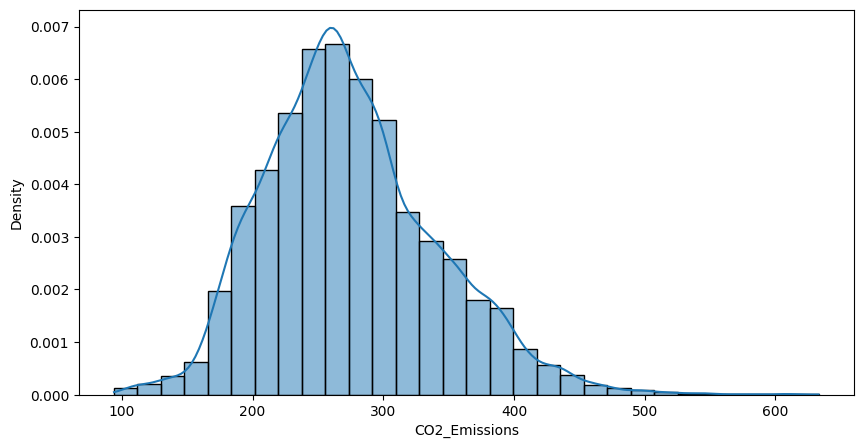

In [20]:
plt.figure(figsize=(10, 5))

sns.histplot(data_df["CO2_Emissions"], bins=30, kde=True, stat="density")

<Figure size 1000x500 with 0 Axes>

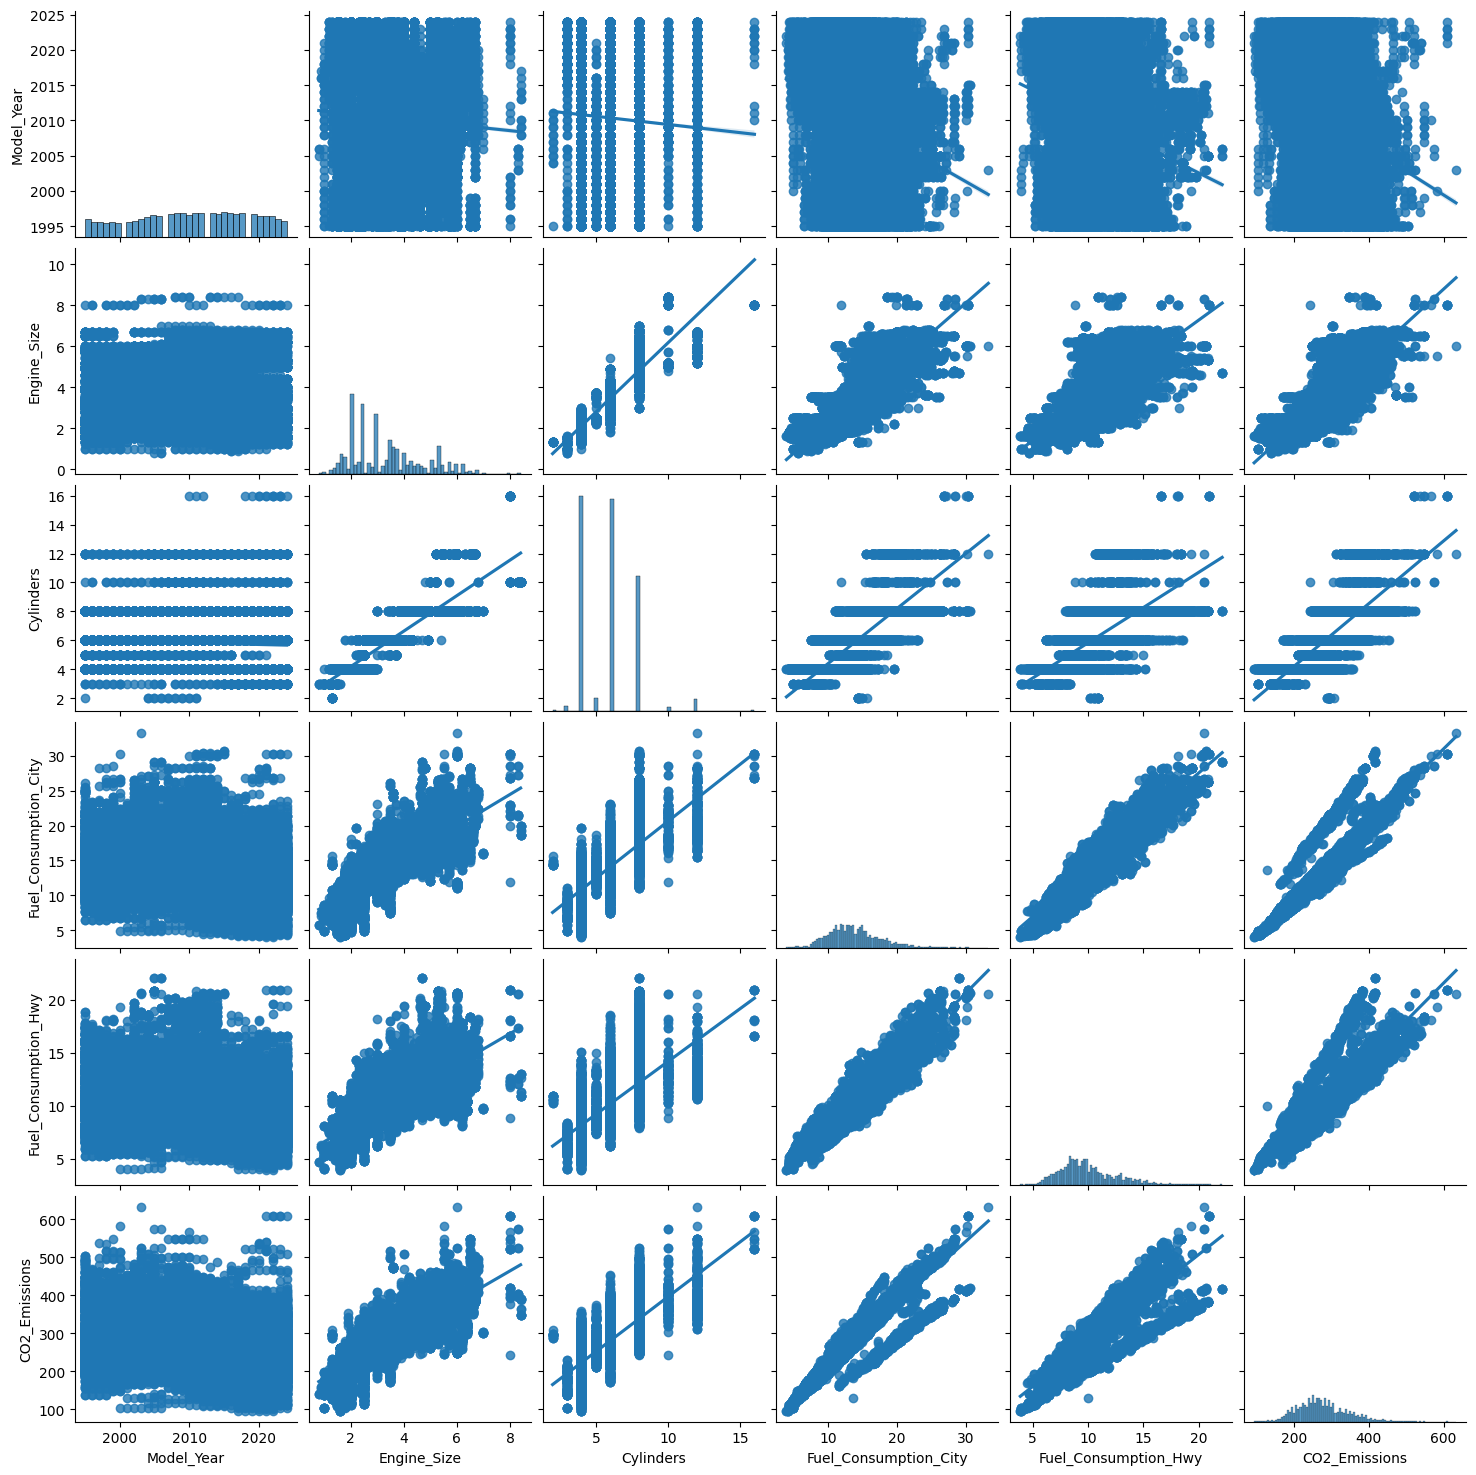

In [21]:
plt.figure(figsize=(10, 5))

sns.pairplot(data_df, kind="reg")
# plt.savefig("figures/pairplot_reg.png", bbox_inches="tight")
plt.show()

### Feature Engineering

In [22]:
data_df_cols = data_df.columns
data_df_cols

Index(['Model_Year', 'Make', 'Model', 'Vehicle_Class', 'Engine_Size',
       'Cylinders', 'Transmission', 'Fuel_Type', 'Fuel_Consumption_City',
       'Fuel_Consumption_Hwy', 'CO2_Emissions'],
      dtype='object')

In [23]:
print(len(data_df[data_df_cols[1]].unique()))
data_df[data_df_cols[1]].unique()

55


array(['ACURA', 'ALFA ROMEO', 'ASTON MARTIN', 'AUDI', 'BENTLEY', 'BMW',
       'BUGATTI', 'BUICK', 'CADILLAC', 'CHEVROLET', 'CHRYSLER', 'DODGE',
       'FIAT', 'FORD', 'GENESIS', 'GMC', 'HONDA', 'HYUNDAI', 'INFINITI',
       'JAGUAR', 'JEEP', 'KIA', 'LAMBORGHINI', 'LAND ROVER', 'LEXUS',
       'LINCOLN', 'MASERATI', 'MAZDA', 'MERCEDES-BENZ', 'MINI',
       'MITSUBISHI', 'NISSAN', 'PORSCHE', 'RAM', 'ROLLS-ROYCE', 'SUBARU',
       'TOYOTA', 'VOLKSWAGEN', 'VOLVO', 'FERRARI', 'PONTIAC', 'SAAB',
       'SATURN', 'SMART', 'SUZUKI', 'HUMMER', 'SCION', 'SRT', 'EAGLE',
       'GEO', 'ISUZU', 'MERCURY', 'OLDSMOBILE', 'PLYMOUTH', 'DAEWOO'],
      dtype=object)

In [24]:
sports = ['BUGATTI', 'PORSCHE', 'MASERATI', 'ASTON MARTIN', 'LAMBORGHINI', 'JAGUAR','SRT', 'FERRARI', 'EAGLE']
premium = ['ALFA ROMEO', 'AUDI', 'BMW', 'BUICK', 'CADILLAC', 'CHRYSLER', 'DODGE', 'GMC','INFINITI', 'JEEP', 
           'LAND ROVER', 'LEXUS', 'MERCEDES-BENZ','MINI', 'SMART', 'VOLVO', 'SAAB']
luxury = ['ACURA', 'BENTLEY', 'LINCOLN', 'ROLLS-ROYCE',  'GENESIS', 'HUMMER']
general = ['CHEVROLET', 'FIAT', 'FORD', 'KIA', 'HONDA', 'HYUNDAI', 'MAZDA', 'MITSUBISHI','NISSAN', 'RAM', 
           'SCION', 'SUBARU', 'TOYOTA','VOLKSWAGEN','PONTIAC', 'SATURN', 'SUZUKI', 'GEO', 'ISUZU', 'MERCURY', 
           'OLDSMOBILE', 'PLYMOUTH', 'DAEWOO']


In [25]:
data_df['Make_Type'] = data_df['Make'].replace(sports, 'Sports')
data_df['Make_Type'] = data_df['Make_Type'].replace(premium,'Premium')
data_df['Make_Type'] = data_df['Make_Type'].replace(luxury, 'Luxury')
data_df['Make_Type'] = data_df['Make_Type'].replace(general,'General')

/var/folders/9m/fnxf5zp57vv4js4fzj03j7km0000gn/T/ipykernel_2908/3186097666.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)


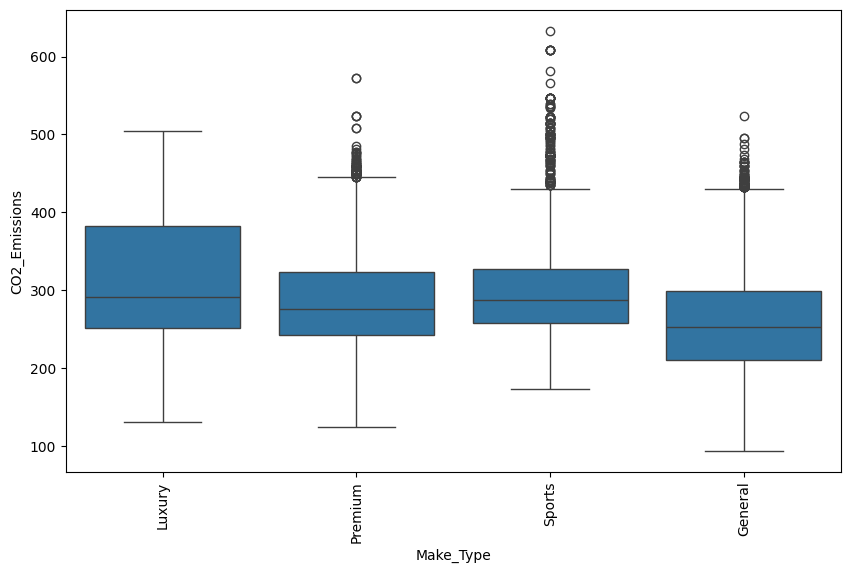

In [26]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x="Make_Type", y="CO2_Emissions", data=data_df)
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
plt.show()

#### Outlier Detection and Removal

In [27]:
df_num_features=data_df.select_dtypes(include=np.number)

In [28]:
Q1 = df_num_features.quantile(0.25)
Q3 = df_num_features.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Model_Year               13.0
Engine_Size               2.0
Cylinders                 4.0
Fuel_Consumption_City     4.7
Fuel_Consumption_Hwy      3.2
CO2_Emissions            84.0
dtype: float64


In [29]:
outlier = pd.DataFrame((df_num_features < (Q1 - 1.5 * IQR)) | (df_num_features > (Q3 + 1.5 * IQR)))

for i in outlier.columns:
    print('Total number of Outliers in column {} are {}'.format(i, (len(outlier[outlier[i] == True][i]))))

Total number of Outliers in column Model_Year are 0
Total number of Outliers in column Engine_Size are 52
Total number of Outliers in column Cylinders are 16
Total number of Outliers in column Fuel_Consumption_City are 584
Total number of Outliers in column Fuel_Consumption_Hwy are 599
Total number of Outliers in column CO2_Emissions are 371


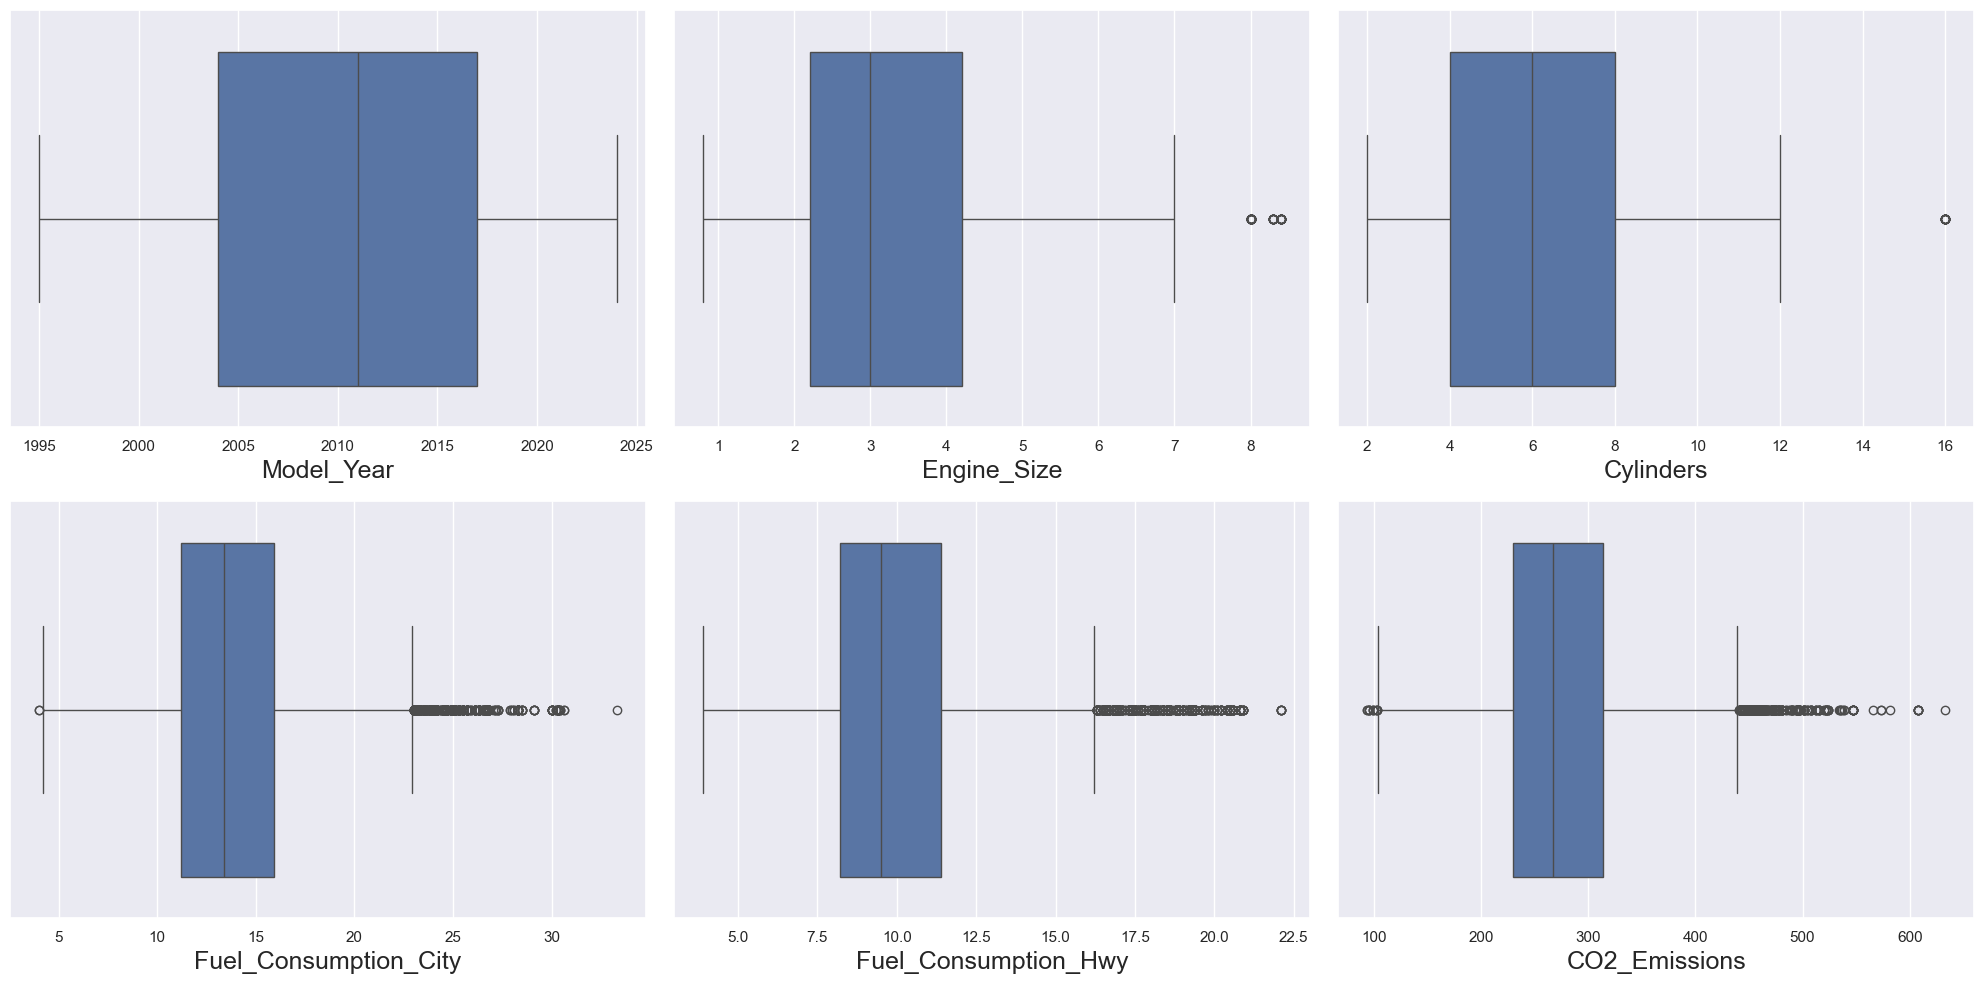

In [30]:
plt.figure(figsize=(20, 10))

for i, column in enumerate(df_num_features, start=1):
    sns.set_theme(style="darkgrid")
    plt.subplot(2,3, i)
    sns.boxplot(x=column, data= df_num_features)
    plt.xlabel(column,fontsize=18)

plt.tight_layout()
plt.savefig("figures/num_outliers.png", bbox_inches="tight")
plt.show()

In [31]:
df_num_features.shape

(27771, 6)

In [32]:
stat, p_value = ss.shapiro(df_num_features)

print('Test statistic:', stat)
print('P-Value:', p_value)

Test statistic: 0.5317691522860641
P-Value: 6.164223303827316e-172


/var/folders/9m/fnxf5zp57vv4js4fzj03j7km0000gn/T/ipykernel_2908/4102385023.py:1: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 166626.
  stat, p_value = ss.shapiro(df_num_features)


In [33]:
# Removing "Model_Year" and "Model" column
data_df.drop(["Model_Year"], inplace=True, axis=1)
data_df.drop(["Model"], inplace=True, axis=1)

# Removing outlier from the dataset
outlier_idx = outlier.index[outlier.any(axis=1)].tolist()
data_df.drop(axis='index', index=outlier_idx, inplace=True)

data_df.reset_index(inplace=True, drop=True)
print(f"New dataset dimension is: {data_df.shape}")

New dataset dimension is: (26913, 10)


In [34]:
data_df.columns

Index(['Make', 'Vehicle_Class', 'Engine_Size', 'Cylinders', 'Transmission',
       'Fuel_Type', 'Fuel_Consumption_City', 'Fuel_Consumption_Hwy',
       'CO2_Emissions', 'Make_Type'],
      dtype='object')

#### Feature Encoding

In [35]:
df_dummies = pd.get_dummies(data = data_df[["Fuel_Type",
                                            "Transmission",
                                            "Make",
                                            "Vehicle_Class"]], drop_first = True)

df_num_features = data_df.select_dtypes(include=np.number)

df_encoded = pd.concat([df_num_features, df_dummies], axis = 1)
df_encoded.head()

,Engine_Size,Cylinders,Fuel_Consumption_City,Fuel_Consumption_Hwy,CO2_Emissions,Fuel_Type_E,Fuel_Type_N,Fuel_Type_X,Fuel_Type_Z,Transmission_A3,...,Vehicle_Class_SPECIAL PURPOSE VEHICLE,Vehicle_Class_SPORT UTILITY VEHICLE,Vehicle_Class_SPORT UTILITY VEHICLE: SMALL,Vehicle_Class_SPORT UTILITY VEHICLE: STANDARD,Vehicle_Class_STATION WAGON: MID-SIZE,Vehicle_Class_STATION WAGON: SMALL,Vehicle_Class_SUBCOMPACT,Vehicle_Class_TWO-SEATER,Vehicle_Class_VAN: CARGO,Vehicle_Class_VAN: PASSENGER
0,2.4,4,9.9,7.0,200,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,3.5,6,12.6,9.4,263,False,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False
2,3.0,6,13.8,11.2,291,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,False
3,3.5,6,11.1,10.8,256,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
4,2.0,4,11.0,8.6,232,False,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False


#### Feature Scaling

In [36]:
# Fuel Consumption Scaling for City
X_fuel_cons_city = df_encoded.drop(['Fuel_Consumption_City', 'Fuel_Consumption_Hwy' , 'CO2_Emissions'], 
                                   axis= 1).astype(np.float32)
y_fuel_cons_city = df_encoded["Fuel_Consumption_City"].astype(np.float32)

X_city = (X_fuel_cons_city - np.min(X_fuel_cons_city)) / (np.max(X_fuel_cons_city) - np.min(X_fuel_cons_city))
y_city = (y_fuel_cons_city - np.min(y_fuel_cons_city)) / (np.max(y_fuel_cons_city) - np.min(y_fuel_cons_city))

In [37]:
# Fuel Consumption Scaling for Highway
X_fuel_cons_hwy = df_encoded.drop(['Fuel_Consumption_City', 'Fuel_Consumption_Hwy' , 'CO2_Emissions'], 
                                  axis= 1).astype(np.float32)
y_fuel_cons_hwy = df_encoded["Fuel_Consumption_Hwy"].astype(np.float32)

X_hwy = (X_fuel_cons_hwy - np.min(X_fuel_cons_hwy)) / (np.max(X_fuel_cons_hwy) - np.min(X_fuel_cons_hwy))
y_hwy = (y_fuel_cons_hwy - np.min(y_fuel_cons_hwy)) / (np.max(y_fuel_cons_hwy) - np.min(y_fuel_cons_hwy))

In [38]:
# Scaling for CO2 Emission
X_co2_em = df_encoded.drop(['CO2_Emissions'], axis= 1).astype(np.float32)
y_co2_em = df_encoded["CO2_Emissions"].astype(np.float32)

X_co2 = (X_co2_em - np.min(X_co2_em)) / (np.max(X_co2_em) - np.min(X_co2_em))
y_co2 = (y_co2_em - np.min(y_co2_em)) / (np.max(y_co2_em) - np.min(y_co2_em))

#### Dataset Split into Train, Validation and Test (80%, 10%, 10%)

In [39]:
X_train_city, X_rem_city, y_train_city, y_rem_city = train_test_split(X_city, y_city, test_size=0.2, random_state=42)
X_val_city, X_test_city, y_val_city, y_test_city = train_test_split(X_rem_city, y_rem_city, test_size=0.5, random_state=42)

print("X_train", X_train_city.shape)
print("y_train",y_train_city.shape)
print("X_val",X_val_city.shape)
print("y_val",y_val_city.shape)
print("X_test",X_test_city.shape)
print("y_test",y_test_city.shape)

X_train (21530, 103)
y_train (21530,)
X_val (2691, 103)
y_val (2691,)
X_test (2692, 103)
y_test (2692,)


In [40]:
X_train_hwy, X_rem_hwy, y_train_hwy, y_rem_hwy = train_test_split(X_hwy, y_hwy, test_size=0.2, random_state=42)
X_val_hwy, X_test_hwy, y_val_hwy, y_test_hwy = train_test_split(X_rem_hwy, y_rem_hwy, test_size=0.5, random_state=42)

print("X_train", X_train_hwy.shape)
print("y_train",y_train_hwy.shape)
print("X_val",X_val_hwy.shape)
print("y_val",y_val_hwy.shape)
print("X_test",X_test_hwy.shape)
print("y_test",y_test_hwy.shape)

X_train (21530, 103)
y_train (21530,)
X_val (2691, 103)
y_val (2691,)
X_test (2692, 103)
y_test (2692,)


In [41]:
X_train_co2, X_rem_co2, y_train_co2, y_rem_co2 = train_test_split(X_co2, y_co2, test_size=0.2, random_state=42)
X_val_co2, X_test_co2, y_val_co2, y_test_co2 = train_test_split(X_rem_co2, y_rem_co2, test_size=0.5, random_state=42)

print("X_train", X_train_co2.shape)
print("y_train",y_train_co2.shape)
print("X_val",X_val_co2.shape)
print("y_val",y_val_co2.shape)
print("X_test",X_test_co2.shape)
print("y_test",y_test_co2.shape)

X_train (21530, 105)
y_train (21530,)
X_val (2691, 105)
y_val (2691,)
X_test (2692, 105)
y_test (2692,)


### Modelling

In [42]:
def train_lr(X_train, y_train):
    model = LinearRegression().fit(X_train, y_train)
    
    return model

In [43]:
def train_random_forest(X_train, y_train):
    model = RandomForestRegressor().fit(X_train, y_train)
    
    return model

In [44]:
def train_gradient_boosting_regression(X_train, y_train, params):
    model = GradientBoostingRegressor(**params).fit(X_train, y_train)
    
    return model

In [45]:
def evaluate(model, X_train, y_train, X_val, y_val,  X_test, y_test):
    train_rmse = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
    val_rmse = np.sqrt(mean_squared_error(y_val, model.predict(X_val)))

    test_rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
    
    r2_train = model.score(X_train, y_train)
    lin_r2_score = cross_val_score(model, X_train, y_train, cv=10, scoring="r2").mean()
    
    return train_rmse, val_rmse, test_rmse, r2_train, lin_r2_score

In [46]:
def predict_and_compare(model, sample_df_Xtest, sample_df_ytest):
    pred = model.predict(sample_df_Xtest)
    
    result_pred = pd.DataFrame({"Pred_Linear": pred, "Real_Value": sample_df_ytest.values})
    result_pred["Pred_Linear"] = result_pred["Pred_Linear"].round(2)
    result_pred["Diff"] = result_pred["Pred_Linear"] - result_pred["Real_Value"]
    mean_diff = abs(result_pred["Diff"]).mean()
    
    return result_pred, mean_diff

#### Linear Regression

In [47]:
def init_training_lr(X_train, y_train, X_val, y_val, X_test, y_test):
    model = train_lr(X_train, y_train)
    train_rmse, val_rmse, test_rmse, r2_train, lin_r2_score = evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test)
    
    linear_regression_pred, mean_diff = predict_and_compare(model, X_test, y_test)

    print(f"Training RMSE: {train_rmse}")
    print(f"Validation RMSE: {val_rmse}")
    print(f"Testing RMSE: {test_rmse}")
    print(f"R^2 score on Training Data: {r2_train}")
    print(f"Cross-validated R^2 score: {lin_r2_score}")
    print(f"Mean Difference: {mean_diff}")

In [48]:
print(f"Training and Evaluation for Fuel Consumption in City")
init_training_lr(X_train_city, y_train_city, X_val_city, y_val_city, X_test_city, y_test_city)

Training and Evaluation for Fuel Consumption in City
Training RMSE: 0.06411051750183105
Validation RMSE: 0.06519738584756851
Testing RMSE: 0.06474564969539642
R^2 score on Training Data: 0.8687652057374015
Cross-validated R^2 score: 0.8674067910693205
Mean Difference: 0.049426618963479996


In [49]:
print(f"Training and Evaluation for Fuel Consumption in Highway")
init_training_lr(X_train_hwy, y_train_hwy, X_val_hwy, y_val_hwy, X_test_hwy, y_test_hwy)

Training and Evaluation for Fuel Consumption in Highway
Training RMSE: 0.07269369065761566
Validation RMSE: 0.07643186300992966
Testing RMSE: 0.07283426076173782
R^2 score on Training Data: 0.8456460124726206
Cross-validated R^2 score: 0.8440813143779581
Mean Difference: 0.05495401844382286


In [50]:
print(f"Training and Evaluation for CO2 Emission")
init_training_lr(X_train_co2, y_train_co2, X_val_co2, y_val_co2, X_test_co2, y_test_co2)

Training and Evaluation for CO2 Emission
Training RMSE: 0.009914173744618893
Validation RMSE: 0.010134703479707241
Testing RMSE: 0.009260300546884537
R^2 score on Training Data: 0.9970556409591659
Cross-validated R^2 score: 0.997019998168121
Mean Difference: 0.005853718146681786


#### Random Forest

In [51]:
def init_training_random_forest(X_train, y_train, X_val, y_val, X_test, y_test):
    model = train_random_forest(X_train, y_train)
    train_rmse, val_rmse, test_rmse, r2_train, lin_r2_score = evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test)
    
    linear_regression_pred, mean_diff = predict_and_compare(model, X_test, y_test)

    print(f"Training RMSE: {train_rmse}")
    print(f"Validation RMSE: {val_rmse}")
    print(f"Testing RMSE: {test_rmse}")
    print(f"R^2 score on Training Data: {r2_train}")
    print(f"Cross-validated R^2 score: {lin_r2_score}")
    print(f"Mean Difference: {mean_diff}")

    return model

In [52]:
print(f"Training and Evaluation for Fuel Consumption in City using Random Forest")
model_rf_city = init_training_random_forest(X_train_city, y_train_city, X_val_city, y_val_city, X_test_city, y_test_city)

Training and Evaluation for Fuel Consumption in City using Random Forest
Training RMSE: 0.03224632643796175
Validation RMSE: 0.037397394816635995
Testing RMSE: 0.03671821092637036
R^2 score on Training Data: 0.9667990173009733
Cross-validated R^2 score: 0.953849680795598
Mean Difference: 0.02546282303649627


In [53]:
print(f"Training and Evaluation for Fuel Consumption in Highway using Random Forest")
model_rf_hwy = init_training_random_forest(X_train_hwy, y_train_hwy, X_val_hwy, y_val_hwy, X_test_hwy, y_test_hwy)

Training and Evaluation for Fuel Consumption in Highway using Random Forest
Training RMSE: 0.04068660231496652
Validation RMSE: 0.0462928308592018
Testing RMSE: 0.04667357845958572
R^2 score on Training Data: 0.9516465780782393
Cross-validated R^2 score: 0.934370268244369
Mean Difference: 0.03255389098714578


In [54]:
print(f"Training and Evaluation for CO2 Emission using Random Forest")
model_rf_co2 = init_training_random_forest(X_train_co2, y_train_co2, X_val_co2, y_val_co2, X_test_co2, y_test_co2)

Training and Evaluation for CO2 Emission using Random Forest
Training RMSE: 0.003360863105587307
Validation RMSE: 0.00792318402449012
Testing RMSE: 0.007345237194284394
R^2 score on Training Data: 0.9996616397453443
Cross-validated R^2 score: 0.998050527491276
Mean Difference: 0.004346710049684254


#### Gradient Boosting Regression

In [55]:
def init_training_gradient_boosting_regression(X_train, y_train, X_val, y_val, X_test, y_test):
    params = {
        "n_estimators": 500,
        "max_depth": 4,
        "min_samples_split": 5,
        "learning_rate": 0.01,
        "loss": "squared_error",
    }
    model = train_gradient_boosting_regression(X_train, y_train, params)
    train_rmse, val_rmse, test_rmse, r2_train, lin_r2_score = evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test)
    
    linear_regression_pred, mean_diff = predict_and_compare(model, X_test, y_test)

    print(f"Training RMSE: {train_rmse}")
    print(f"Validation RMSE: {val_rmse}")
    print(f"Testing RMSE: {test_rmse}")
    print(f"R^2 score on Training Data: {r2_train}")
    print(f"Cross-validated R^2 score: {lin_r2_score}")
    print(f"Mean Difference: {mean_diff}")

In [56]:
print(f"Training and Evaluation for Fuel Consumption in City using Gradient Boosting Regression")
init_training_gradient_boosting_regression(X_train_city, y_train_city, X_val_city, y_val_city, X_test_city, y_test_city)

Training and Evaluation for Fuel Consumption in City using Gradient Boosting Regression
Training RMSE: 0.06621186167499507
Validation RMSE: 0.06701758514752078
Testing RMSE: 0.06780257091660452
R^2 score on Training Data: 0.8600212715122916
Cross-validated R^2 score: 0.8574741656165588
Mean Difference: 0.05236256084742541


In [57]:
print(f"Training and Evaluation for Fuel Consumption in Highway using Gradient Boosting Regression")
init_training_gradient_boosting_regression(X_train_hwy, y_train_hwy, X_val_hwy, y_val_hwy, X_test_hwy, y_test_hwy)

Training and Evaluation for Fuel Consumption in Highway using Gradient Boosting Regression
Training RMSE: 0.0777369657692484
Validation RMSE: 0.07951758321875477
Testing RMSE: 0.07716362848130276
R^2 score on Training Data: 0.823485845594075
Cross-validated R^2 score: 0.8201385260934281
Mean Difference: 0.059714024586140856


In [58]:
print(f"Training and Evaluation for CO2 Emission using Gradient Boosting Regression")
init_training_gradient_boosting_regression(X_train_co2, y_train_co2, X_val_co2, y_val_co2, X_test_co2, y_test_co2)

Training and Evaluation for CO2 Emission using Gradient Boosting Regression
Training RMSE: 0.011284435609776431
Validation RMSE: 0.012630215378049781
Testing RMSE: 0.011505319312659096
R^2 score on Training Data: 0.9961855020811611
Cross-validated R^2 score: 0.9958244990262537
Mean Difference: 0.007572520352086333


#### Neural Network Regression

In [59]:
class NNRegressor:
    def __init__(self, cols=103):
        self.nn = tf.keras.models.Sequential()
        self.nn.add(Input(shape=(cols, )))
        self.nn.add(Dense(256, activation='relu'))
        self.nn.add(Dense(128, activation='relu'))
        self.nn.add(Dense(64, activation='relu'))
        self.nn.add(Dense(32, activation='relu'))
        self.nn.add(Dense(16, activation='relu'))
        self.nn.add(Dense(1, activation='sigmoid'))

    def train(self, X_train, y_train, X_val, y_val):
        self.nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
        model = self.nn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20)

        return model

In [60]:
def evaluate_nn(model, X_train, y_train, X_val, y_val,  X_test, y_test):
    train_rmse = np.sqrt(mean_squared_error(y_train, model.nn.predict(X_train)))
    val_rmse = np.sqrt(mean_squared_error(y_val, model.nn.predict(X_val)))

    test_rmse = np.sqrt(mean_squared_error(y_test, model.nn.predict(X_test)))
    
    # r2_train = model.score(X_train, y_train)
    # lin_r2_score = cross_val_score(model, X_train, y_train, cv=10, scoring="r2").mean()
    
    return train_rmse, val_rmse, test_rmse
    # r2_train, lin_r2_score

In [61]:
nn_regressor = NNRegressor()
nn_regressor_model = nn_regressor.train(X_train_city, y_train_city, X_val_city, y_val_city)

Epoch 1/20
673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 768us/step - accuracy: 1.1457e-04 - loss: 0.6469 - val_accuracy: 0.0000e+00 - val_loss: 0.6338
Epoch 2/20
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - accuracy: 2.8554e-04 - loss: 0.6339 - val_accuracy: 0.0000e+00 - val_loss: 0.6325
Epoch 3/20
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - accuracy: 1.0572e-04 - loss: 0.6329 - val_accuracy: 0.0000e+00 - val_loss: 0.6311
Epoch 4/20
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - accuracy: 2.1199e-04 - loss: 0.6327 - val_accuracy: 0.0000e+00 - val_loss: 0.6340
Epoch 5/20
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - accuracy: 2.7608e-04 - loss: 0.6319 - val_accuracy: 0.0000e+00 - val_loss: 0.6305
Epoch 6/20
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - accuracy: 1.7546e-04 - loss: 0.6315 - val_accuracy: 0.0000e+00 - val_loss: 0.6300
Epoch 7/20
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - accuracy: 1.4570e-04 - loss: 0.6303 - val_accuracy: 0.0000e+00 - val_loss: 0.6301
Epoch 8/20
673/673 ━━━━━━━━━━━━━━━

In [62]:
evaluate_nn(nn_regressor, X_train_city, y_train_city, X_val_city, y_val_city, X_test_city, y_test_city)

673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


(0.040775366, 0.043708064, 0.044074975)

In [63]:
nn_regressor_hwy = NNRegressor()
nn_regressor_model_hwy = nn_regressor_hwy.train(X_train_hwy, y_train_hwy, X_val_hwy, y_val_hwy)

Epoch 1/20
673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step - accuracy: 4.0493e-04 - loss: 0.6447 - val_accuracy: 0.0000e+00 - val_loss: 0.6289
Epoch 2/20
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - accuracy: 2.8594e-04 - loss: 0.6290 - val_accuracy: 0.0000e+00 - val_loss: 0.6285
Epoch 3/20
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - accuracy: 4.6588e-04 - loss: 0.6271 - val_accuracy: 0.0000e+00 - val_loss: 0.6255
Epoch 4/20
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - accuracy: 4.0640e-04 - loss: 0.6263 - val_accuracy: 0.0000e+00 - val_loss: 0.6251
Epoch 5/20
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - accuracy: 1.2914e-04 - loss: 0.6266 - val_accuracy: 0.0000e+00 - val_loss: 0.6248
Epoch 6/20
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - accuracy: 2.8429e-04 - loss: 0.6255 - val_accuracy: 0.0000e+00 - val_loss: 0.6246
Epoch 7/20
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - accuracy: 3.2132e-04 - loss: 0.6263 - val_accuracy: 0.0000e+00 - val_loss: 0.6244
Epoch 8/20
673/673 ━━━━━━━━━━━━━━━

In [64]:
evaluate_nn(nn_regressor_hwy, X_train_hwy, y_train_hwy, X_val_hwy, y_val_hwy, X_test_hwy, y_test_hwy)

673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step


(0.04805658, 0.051822506, 0.051873002)

In [65]:
nn_regressor_co2 = NNRegressor(cols=X_train_co2.shape[1])
nn_regressor_model_co2 = nn_regressor_co2.train(X_train_co2, y_train_co2, X_val_co2, y_val_co2)

Epoch 1/20
673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 822us/step - accuracy: 8.2076e-04 - loss: 0.6377 - val_accuracy: 7.4322e-04 - val_loss: 0.6214
Epoch 2/20
673/673 ━━━━━━━━━━━━━━━━━━━━ 1s 741us/step - accuracy: 0.0011 - loss: 0.6218 - val_accuracy: 7.4322e-04 - val_loss: 0.6204
Epoch 3/20
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - accuracy: 0.0012 - loss: 0.6211 - val_accuracy: 7.4322e-04 - val_loss: 0.6203
Epoch 4/20
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - accuracy: 0.0013 - loss: 0.6217 - val_accuracy: 7.4322e-04 - val_loss: 0.6201
Epoch 5/20
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - accuracy: 0.0011 - loss: 0.6210 - val_accuracy: 7.4322e-04 - val_loss: 0.6202
Epoch 6/20
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - accuracy: 0.0019 - loss: 0.6203 - val_accuracy: 7.4322e-04 - val_loss: 0.6201
Epoch 7/20
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - accuracy: 9.5525e-04 - loss: 0.6191 - val_accuracy: 7.4322e-04 - val_loss: 0.6201
Epoch 8/20
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step 

In [66]:
evaluate_nn(nn_regressor_co2, X_train_co2, y_train_co2, X_val_co2, y_val_co2, X_test_co2, y_test_co2)

673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step


(0.00797414, 0.008064915, 0.007991241)

#### Model Explainability

In [67]:
explainer_city = shap.TreeExplainer(model_rf_city)

In [68]:
# Calculate Shap values
choosen_idx = 100
choosen_instance = X_test_city.iloc[[choosen_idx]]
shap_values = explainer_city.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(y_test_city.iloc[[choosen_idx]].iloc[0], shap_values[0], choosen_instance)

In [69]:
shap_values_all = explainer_city.shap_values(X_test_city.iloc[:500])

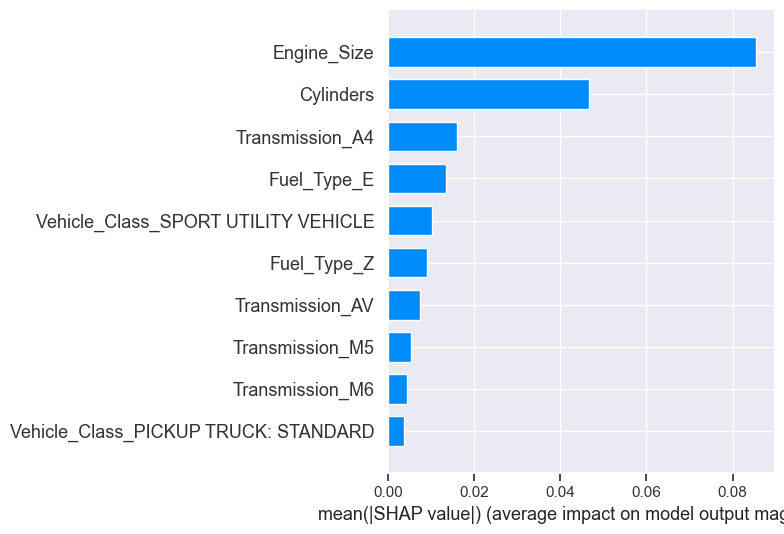

In [70]:
shap.summary_plot(shap_values_all, X_test_city.iloc[:500], max_display=10, plot_type="bar")

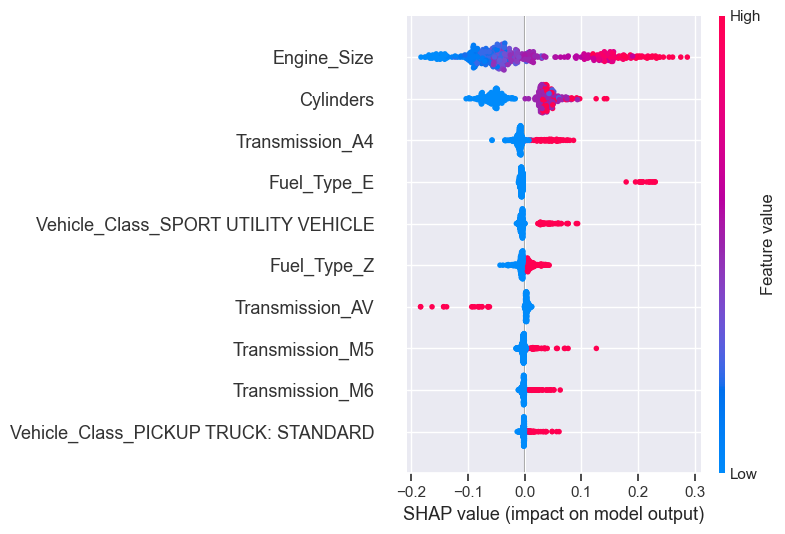

In [71]:
shap.summary_plot(shap_values_all, X_test_city.iloc[:500], max_display=10)

In [97]:
data_df["Transmission"].unique()

array(['AM8', 'AS10', 'AM9', 'A8', 'A9', 'AM7', 'AS8', 'M6', 'AS6', 'AV',
       'AS9', 'A10', 'A6', 'M5', 'M7', 'AV7', 'AV1', 'AM6', 'AS7', 'AV8',
       'AV6', 'AV10', 'AS5', 'A7', 'A4', 'A5', 'AS4', 'M4', 'AM5', 'A3'],
      dtype=object)

In [98]:
data_df["Vehicle_Class"].unique()

array(['COMPACT', 'SPORT UTILITY VEHICLE: SMALL',
       'SPORT UTILITY VEHICLE: STANDARD', 'TWO-SEATER', 'MID-SIZE',
       'MINICOMPACT', 'SUBCOMPACT', 'STATION WAGON: SMALL',
       'STATION WAGON: MID-SIZE', 'FULL-SIZE', 'PICKUP TRUCK: SMALL',
       'PICKUP TRUCK: STANDARD', 'MINIVAN', 'SPECIAL PURPOSE VEHICLE',
       'VAN: PASSENGER', 'SPORT UTILITY VEHICLE', 'VAN: CARGO'],
      dtype=object)

In [102]:
data_df["Fuel_Type"].unique()

array(['Z', 'X', 'D', 'E', 'N'], dtype=object)

In [103]:
data_df["Make"].unique()

array(['ACURA', 'ALFA ROMEO', 'ASTON MARTIN', 'AUDI', 'BENTLEY', 'BMW',
       'BUICK', 'CADILLAC', 'CHEVROLET', 'CHRYSLER', 'DODGE', 'FIAT',
       'FORD', 'GENESIS', 'GMC', 'HONDA', 'HYUNDAI', 'INFINITI', 'JAGUAR',
       'JEEP', 'KIA', 'LAMBORGHINI', 'LAND ROVER', 'LEXUS', 'LINCOLN',
       'MASERATI', 'MAZDA', 'MERCEDES-BENZ', 'MINI', 'MITSUBISHI',
       'NISSAN', 'PORSCHE', 'RAM', 'ROLLS-ROYCE', 'SUBARU', 'TOYOTA',
       'VOLKSWAGEN', 'VOLVO', 'PONTIAC', 'SAAB', 'SATURN', 'SMART',
       'SUZUKI', 'FERRARI', 'HUMMER', 'SCION', 'EAGLE', 'GEO', 'ISUZU',
       'MERCURY', 'OLDSMOBILE', 'PLYMOUTH', 'DAEWOO'], dtype=object)

In [96]:
data_df["Make_Type"].unique()

array(['Luxury', 'Premium', 'Sports', 'General'], dtype=object)

In [93]:
data_df.columns

Index(['Make', 'Vehicle_Class', 'Engine_Size', 'Cylinders', 'Transmission',
       'Fuel_Type', 'Fuel_Consumption_City', 'Fuel_Consumption_Hwy',
       'CO2_Emissions', 'Make_Type'],
      dtype='object')

In [107]:
# Transmission: ['AM8', 'AS10', 'AM9', 'A8', 'A9', 'AM7', 'AS8', 'M6', 'AS6', 'AV',
       # 'AS9', 'A10', 'A6', 'M5', 'M7', 'AV7', 'AV1', 'AM6', 'AS7', 'AV8',
       # 'AV6', 'AV10', 'AS5', 'A7', 'A4', 'A5', 'AS4', 'M4', 'AM5', 'A3']
# Vehicle_Class: ['COMPACT', 'SPORT UTILITY VEHICLE: SMALL',
       # 'SPORT UTILITY VEHICLE: STANDARD', 'TWO-SEATER', 'MID-SIZE',
       # 'MINICOMPACT', 'SUBCOMPACT', 'STATION WAGON: SMALL',
       # 'STATION WAGON: MID-SIZE', 'FULL-SIZE', 'PICKUP TRUCK: SMALL',
       # 'PICKUP TRUCK: STANDARD', 'MINIVAN', 'SPECIAL PURPOSE VEHICLE',
       # 'VAN: PASSENGER', 'SPORT UTILITY VEHICLE', 'VAN: CARGO']
# Fuel_Type: ['Z', 'X', 'D', 'E', 'N']
# Make_Type: ['Make', 'Vehicle_Class', 'Engine_Size', 'Cylinders', 'Transmission',
       # 'Fuel_Type', 'Fuel_Consumption_City', 'Fuel_Consumption_Hwy',
       # 'CO2_Emissions', 'Make_Type']

input_data = {
    'Engine_Size': [2], 
    'Cylinders': [2], 
    'Transmission': ["AM8"],
    'Vehicle_Class': ["COMPACT"],
    'Fuel_Type': ["Z"],
    "Make": ["ACURA"]
}

input_df =  pd.DataFrame.from_dict(input_data)
encoded_in = encoder.fit_transform(input_df[["Fuel_Type", "Transmission", "Make", "Vehicle_Class"]])

In [100]:
def minmax_rescaling(y, model_type):
    if model_type == "city":
        return y * (np.max(y_fuel_cons_city) - np.min(y_fuel_cons_city)) + np.min(y_fuel_cons_city)

    elif model_type == "hwy":
        return y * (np.max(y_fuel_cons_hwy) - np.min(y_fuel_cons_hwy)) + np.min(y_fuel_cons_hwy)

    elif model_type == "co2":
        return y * (np.max(y_co2_em) - np.min(y_co2_em)) + np.min(y_co2_em)


In [85]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first')
encoded_data = encoder.fit_transform(data_df[["Fuel_Type", "Transmission","Make", "Vehicle_Class"]])

In [86]:
encoded_data

<26913x101 sparse matrix of type '<class 'numpy.float64'>'
	with 102747 stored elements in Compressed Sparse Row format>

In [89]:
encoded_data.toarray()[0] 

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [91]:
print(df_dummies.columns)

Index(['Fuel_Type_E', 'Fuel_Type_N', 'Fuel_Type_X', 'Fuel_Type_Z',
       'Transmission_A3', 'Transmission_A4', 'Transmission_A5',
       'Transmission_A6', 'Transmission_A7', 'Transmission_A8',
       ...
       'Vehicle_Class_SPECIAL PURPOSE VEHICLE',
       'Vehicle_Class_SPORT UTILITY VEHICLE',
       'Vehicle_Class_SPORT UTILITY VEHICLE: SMALL',
       'Vehicle_Class_SPORT UTILITY VEHICLE: STANDARD',
       'Vehicle_Class_STATION WAGON: MID-SIZE',
       'Vehicle_Class_STATION WAGON: SMALL', 'Vehicle_Class_SUBCOMPACT',
       'Vehicle_Class_TWO-SEATER', 'Vehicle_Class_VAN: CARGO',
       'Vehicle_Class_VAN: PASSENGER'],
      dtype='object', length=101)


In [92]:
encoder.get_feature_names_out(input_features=["Fuel_Type", "Transmission","Make", "Vehicle_Class"])

array(['Fuel_Type_E', 'Fuel_Type_N', 'Fuel_Type_X', 'Fuel_Type_Z',
       'Transmission_A3', 'Transmission_A4', 'Transmission_A5',
       'Transmission_A6', 'Transmission_A7', 'Transmission_A8',
       'Transmission_A9', 'Transmission_AM5', 'Transmission_AM6',
       'Transmission_AM7', 'Transmission_AM8', 'Transmission_AM9',
       'Transmission_AS10', 'Transmission_AS4', 'Transmission_AS5',
       'Transmission_AS6', 'Transmission_AS7', 'Transmission_AS8',
       'Transmission_AS9', 'Transmission_AV', 'Transmission_AV1',
       'Transmission_AV10', 'Transmission_AV6', 'Transmission_AV7',
       'Transmission_AV8', 'Transmission_M4', 'Transmission_M5',
       'Transmission_M6', 'Transmission_M7', 'Make_ALFA ROMEO',
       'Make_ASTON MARTIN', 'Make_AUDI', 'Make_BENTLEY', 'Make_BMW',
       'Make_BUICK', 'Make_CADILLAC', 'Make_CHEVROLET', 'Make_CHRYSLER',
       'Make_DAEWOO', 'Make_DODGE', 'Make_EAGLE', 'Make_FERRARI',
       'Make_FIAT', 'Make_FORD', 'Make_GENESIS', 'Make_GEO', 'Make